In [1]:
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import json
from tqdm import tqdm
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence
from gensim.models.ldamulticore import LdaMulticore
# spacy for lemmatization
import spacy
# NLTK for text cleaning
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords, names
from nltk.tokenize import RegexpTokenizer
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# TextBlob package for translation and spelling correction
from textblob import TextBlob

nlp = spacy.load('en')
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# %matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


mallet_lda_topics={
                0:'Hotel Staff',
                1:'Accessibility',
                2:'Food',
                3:'Overall Experience',
                4:'Noise',
                5:'Value for Money',
                6:'Room Amenities',
                7:'Location in the city',
                8:'Overall Experience',
                9:'Cleanliness',
                10:'Early Check-in/Late Check-out',
                11:'Health and Wellness Amenities',
                12:'Booking Experience',
                13:'Sleep Quality',
                14:'Parking Facility'
            }


def get_text(rev):
    if pd.DataFrame(rev).empty:
        return ''
    else:
        return rev[0] if str(rev)!='nan' else ''

def review_cleaned(review_df):
    df = review_df[['HotelName','PositiveReview','NegativeReview','StayDate']].copy()#.applymap(get_text)
    df['FullReview'] = [pos+' '+neg for pos,neg in zip(df['PositiveReview'],df['NegativeReview'])]
#     df['StayDate'] = df['StayDate'].apply(lambda x: x.replace('\n','')).apply(lambda x: x.replace('Stayed in ',''))
    return df

def review_to_sentence(df):
    all_sentences = []
    from nltk.tokenize import sent_tokenize
    import pandas as pd
    allreview = df['FullReview']
    for areview in allreview:
        all_sentences.extend(sent_tokenize(areview))
    tokensentence = pd.DataFrame(data=all_sentences,columns=['TokenSentence'])
    return tokensentence

def sentence_sentiment(text):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    compound_sentiment = analyzer.polarity_scores(text)['compound']
    return compound_sentiment

def token_to_sentiment(df):
    df['CompoundSentiment'] = df['TokenSentence'].apply(sentence_sentiment)
    return df

# helper functions for text preprocessing & LDA modeling:

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """

    return token.is_punct or token.is_space or token.like_num or token.is_digit

def line_review(filename):
    """
    generator function to read in reviews from Pandas Series
    and un-escape the original line breaks in the text
    """

    #with codecs.open(filename, encoding='utf_8') as f:
    for review in filename:
        yield review.replace('\\n', '\n')

def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """

    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=10):
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    # load finished dictionary from disk
    trigram_dictionary = Dictionary.load('/home/argha/Desktop/application/src/saved_model/models2/trigram_dict_all.dict')

    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

def nCPU():
    import multiprocessing
    N = multiprocessing.cpu_count()-1
    return N

def topic_extractor(df, min_topic_freq=0.10):
    from tqdm import tqdm
    from operator import itemgetter
    ncpu = nCPU()
    dfc=df.copy()
    text = dfc['TokenSentence'].copy()
    trigram_dictionary = Dictionary.load('/home/argha/Desktop/application/src/saved_model/models2/trigram_dict_all.dict')
    lda = LdaMulticore.load('/home/argha/Desktop/application/src/saved_model/models2/mallet_lda_model')
    # trigram_review = LineSentence('./tri_temporary.txt')
    bigram_model = Phrases.load('/home/argha/Desktop/application/src/saved_model/models2/bigram_model.txt')
    trigram_model = Phrases.load('/home/argha/Desktop/application/src/saved_model/models2/trigram_model.txt')
    topic_list = []
    trigram_list = []
    freq_list = []
    # parse the review text with spaCy
    for parsed_review in tqdm(nlp.pipe(line_review(text),
                                    batch_size=10000, n_threads=ncpu)):
        # lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in parsed_review
                            if not punct_space(token)]
        # apply the first-order and second-order phrase models
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]

        common_terms = ['-PRON-','hotel'] #'service',
        # remove any remaining stopwords
        trigram_review = [term for term in trigram_review
                            if term not in spacy.lang.en.stop_words.STOP_WORDS]
        trigram_review = [term for term in trigram_review
                            if term not in common_terms]
        if len(trigram_review)==0:
            topic_number=-1
            freq = 0.0
            tri = str([])
        else:
            # create a bag-of-words representation
            review_bow = trigram_dictionary.doc2bow(trigram_review)
            # create an LDA representation
            review_lda = lda.get_document_topics(review_bow)
            # print the most highly related topic name and frequency
            review_lda = sorted(review_lda, key=itemgetter(1),reverse=True)[0]
            topic_number = review_lda[0]
            freq = review_lda[1]
            if freq < min_topic_freq:
                topic_number=-1
                freq = 0.0

        topic_list.append(topic_number)
        freq_list.append(round(freq,2))
        trigram_list.append(trigram_review)
    dfc['Topic']=topic_list
    dfc['TopicFrequency']=freq_list
    dfc['Trigram']=trigram_list
    return dfc

def topic_scorer(df):
    xdf = pd.get_dummies(df,prefix='Topic',
                     prefix_sep='_', dummy_na=False,
                     columns=['Topic'])
    topics = ['Topic_0', 'Topic_1', 'Topic_2','Topic_3',
              'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7',
              'Topic_8','Topic_9', 'Topic_10', 'Topic_11',
              'Topic_12', 'Topic_13','Topic_14']
    topic_dict = {}
    for atopic in topics:
        if atopic in xdf.columns.values:
            xdf[atopic] = xdf[atopic] * xdf['CompoundSentiment']
            m = list(filter(lambda a: a != 0, xdf[atopic]))
            topic_dict[atopic] = round(np.mean(m),2)
            topic_dict[atopic+'_scores'] = m
        else:
            topic_dict[atopic] = np.nan
            topic_dict[atopic+'_scores'] = [np.nan]
    return topic_dict

def demo_(hotel_name):
    new_doc = alldata[alldata['HotelName']==hotel_name]
    # print(new_doc.shape)
    text = review_cleaned(new_doc)
    tokensentence = review_to_sentence(text)
    sentencesentiment = token_to_sentiment(tokensentence)
    topicdf = topic_extractor(sentencesentiment)
    topic_dict = topic_scorer(topicdf)
    topic_dict['HotelName']=hotel_name
    return topic_dict#[(key,int(100*topic_dict[key])) for key in topic_dict]


/home/argha/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/argha/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
alldata = pd.read_json('/home/argha/Desktop/application/src/demo_data.json',orient='columns',encoding='utf-8')

In [3]:
alldata.sample(2)

HotelName  \
612828           The Garland   
503668  Sunset Marquis Hotel   

                                           PositiveReview  \
612828  Location and Great shuttle service to universa...   
503668  Great position on Sunset strip, staff extremel...   

                                           NegativeReview       StayDate  
612828  A little pricey for food and drinks at the hotel.      July 2017  
503668      Fee charged wi fi is nonsense in 2018, sorry.  December 2018

In [4]:
# # mallet_lda_topics[int(atopic.replace('Topic_',''))]
# hotel_names = alldata['HotelName'].unique()
# topic_scores=[]
# for hotel_name in tqdm(hotel_names):
#     topic_scores.append(demo_(hotel_name))

In [5]:
# pd.DataFrame(topic_scores).to_json('./topic_scores.json')

In [6]:
ddf = pd.read_json('./topic_scores.json')

In [7]:
topics = ['HotelName','Topic_0', 'Topic_1', 'Topic_2','Topic_3',
              'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7',
              'Topic_8','Topic_9', 'Topic_10', 'Topic_11',
              'Topic_12', 'Topic_13','Topic_14']
ddf[topics].head(2)

HotelName  Topic_0  Topic_1  Topic_2  Topic_3  Topic_4  \
0              Adelphi Hotel     0.69     0.72     0.77      NaN    -0.32   
1  1000 Islands Harbor Hotel     0.71     0.74     0.46     0.55    -0.14   

   Topic_5  Topic_6  Topic_7  Topic_8  Topic_9  Topic_10  Topic_11  Topic_12  \
0     0.65     0.60      NaN     0.42     0.40      0.06      0.79      0.55   
1     0.60    -0.06     0.65     0.42    -0.08      0.41      0.63     -0.20   

   Topic_13  Topic_14  
0       NaN     -0.42  
1      0.35     -0.24

In [8]:
# nystar = pd.read_json('/home/argha/Dropbox/data-files/hotel_info/NewYorkState_hotels_stars.json',encoding='utf-8', lines=True)
# calistar = pd.read_json('/home/argha/Dropbox/data-files/hotel_info/CaliforniaState_hotels_stars.json',encoding='utf-8', lines=True)

In [9]:
# def get_text(rev):
#     return rev[0] if str(rev)!='nan' else ''
# def get_star(x):
#     import re
#     return re.sub("\D", "", x)

# all_star = pd.concat([nystar,calistar],ignore_index=True)
# all_star = all_star.applymap(get_text)
# all_star['HotelStar'] = all_star['HotelStar'].apply(get_star)

In [10]:
# star_score_df = pd.merge(all_star,ddf,on='HotelName')

In [11]:
# star_score_df.head(3)

In [12]:
# pd.DataFrame(star_score_df).to_json('./hotel_star_scores.json')

In [13]:
star_score_df = pd.read_json('/home/argha/Dropbox/review-data/wk3/hotel_star_scores.json',encoding='utf-8')

In [14]:
star_score_df.head(1)

HotelID    HotelName HotelStar  Topic_0  \
0  2339211  Miami Motel               0.72   

                                      Topic_0_scores  Topic_1  Topic_10  \
0  [0.8129000000000001, 0.742, 0.7184, 0.42150000...     0.05       NaN   

  Topic_10_scores  Topic_11  \
0              []      0.69   

                                     Topic_11_scores  \
0  [0.4404, 0.5994, 0.5994, 0.5267000000000001, 0...   

                ...                Topic_5  \
0               ...                   0.79   

                                      Topic_5_scores  Topic_6  \
0  [0.6361, 0.8885000000000001, 0.8096, 0.8617, 0...      0.3   

                                   Topic_6_scores  Topic_7 Topic_7_scores  \
0  [0.33840000000000003, 0.8519, 0.6249, -0.5956]      NaN         [None]   

  Topic_8                                     Topic_8_scores Topic_9  \
0    0.47  [0.4927, 0.3612, -0.4767, 0.7351000000000001, ...    0.15   

                   Topic_9_scores  
0  [-0.1027, 0.40190000000000003]  

[1 rows x 33 columns]

In [15]:
pwd

'/home/argha/Dropbox/review-data/wk3'

In [16]:
def score_compare(hotelname, star_rating):
    topics = ['Topic_0', 'Topic_1', 'Topic_2','Topic_3',
              'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7',
              'Topic_8','Topic_9', 'Topic_10', 'Topic_11',
              'Topic_12', 'Topic_13','Topic_14']
    mallet_lda_topics={
                0:'Hotel Staff',
                1:'Accessibility',
                2:'Food',
                3:'Overall Experience',
                4:'Noise',
                5:'Value for Money',
                6:'Room Amenities',
                7:'Location in the city',
                8:'Overall Experience',
                9:'Cleanliness',
                10:'Early Check-in/Late Check-out',
                11:'Health and Wellness Amenities',
                12:'Booking Experience',
                13:'Sleep Quality',
                14:'Parking Facility'
            }
    df_myhotel = star_score_df[star_score_df['HotelName']==hotelname]
    df = star_score_df[star_score_df['HotelStar']==str(star_rating)]
    fig, ax = plt.subplots(figsize=(10, 60))
    for i in range(len(topics)):
        atopic = topics[i]
        scores_dict = {}
        if atopic in df_myhotel.columns.values:
            myscore = 100.*float(df_myhotel[atopic])
            otherscore = 100.*pd.Series(df[atopic].values, name = mallet_lda_topics[int(atopic.replace('Topic_',''))]).dropna()
            othermean = 100.*np.mean(otherscore)
            if myscore > othermean:
                print(myscore)
            
            scores_dict[atopic] = [myscore,othermean]
            plt.subplot(len(topics),1,i+1)
            ax = sns.distplot(otherscore, color='y')
            ax.axvline(myscore, 0,1.0);
#         import seaborn as sns
#         import pandas as pd
#         fig, ax = plt.subplots(figsize=(10, 14))
#         plt.subplot(2,1,1)
#         x1 = pd.Series(s3['Topic_3'].values, name="Topic_3").dropna()
#         ax = sns.distplot(x1, color='y')
#         ax.axvline(.38, 0,1.0);
#         plt.subplot(2,1,2)
#         x2 = pd.Series(s3['Topic_1'].values, name="Topic_1").dropna()
#         ax = sns.distplot(x2, color='y')
#         ax.axvline(.8, 0,1.0);

UnboundLocalError: local variable 'othermean' referenced before assignment

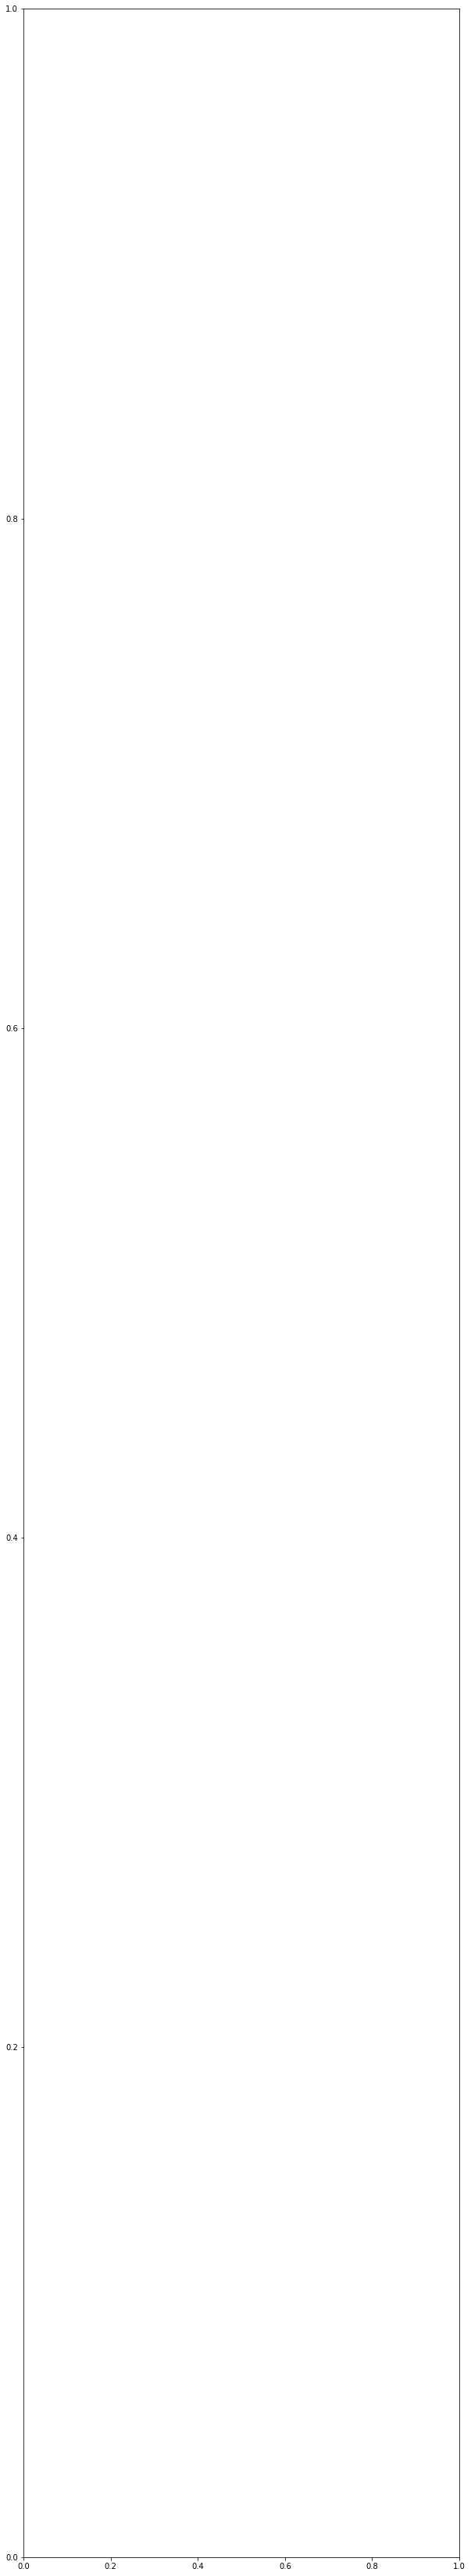

In [17]:
score_compare('Adelphi Hotel',5)

In [ ]:
def compare_plot(hotel_name, hotel_star, atopic):
    from io import StringIO
    import base64
    df_myhotel = star_score_df[star_score_df['HotelName']==hotel_name]
    df = star_score_df[star_score_df['HotelStar']==str(hotel_star)]
    myscore = 100.*float(df_myhotel[atopic])
    otherscore = 100.*pd.Series(df[atopic].values, name = mallet_lda_topics[int(atopic.replace('Topic_',''))]).dropna()
#     fig = StringIO()
    sns.set_style("dark") #E.G.
    fig, ax = plt.subplots(figsize=(10, 10));
    ax = sns.distplot(otherscore, color='y');
    ax.axvline(myscore, 0,1.0);
    
    # Make Matplotlib write to BytesIO file object and grab
    # return the object's string
    from io import BytesIO
    figfile = BytesIO()
    fig.savefig(figfile, format='png')
    figfile.seek(0)  # rewind to beginning of file
    import base64
    figdata_png = base64.b64encode(figfile.getvalue())
    return figdata_png


In [ ]:
plot_url = compare_plot('Adelphi Hotel',5,'Topic_0')

In [1]:
print(sc.version)

NameError: name 'sc' is not defined

In [2]:
from pyspark import SparkContext, SparkConf